<a href="https://colab.research.google.com/github/nilkis/phoenix/blob/master/01_VRMS3_B3_exp_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
from datetime import datetime
import pandas as pd
import glob
import scipy
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ls 'gdrive/My Drive'

 발표자료		  books		     education	 team-seminar
'Backup 2019-04-16.zip'  'Colab Notebooks'   hobby	 work


In [0]:
## load data
#vrms_file3='./vrms/4th_test.csv'
#vrms_file3='https://github.com/nilkis/rul/blob/master/vrms/4th_test.csv'
vrms_file3='./gdrive/My Drive/work/2019/CJ-logistics/04.model/vrms/4th_test.csv'
vrms3 = pd.read_csv(vrms_file3)
Xt_all = vrms3['B3'].values

In [15]:
# Failure Threshold
W = np.log(6) # failure threshold

# time delta
T_delta = 1

# normal state static
Xt_normal = Xt_all[1000:5000]
avg_normal = np.mean(Xt_normal)
std_normal = np.std(Xt_normal)
FPT_threshold = avg_normal + std_normal * 6 # TODO
FPT_threshold = 1.2
print ("avg_normal=%f, std_normal = %f, avg+3std = %f, W = %f" % (avg_normal, std_normal, FPT_threshold, W))

avg_normal=0.547078, std_normal = 0.017335, avg+3std = 1.200000, W = 1.791759


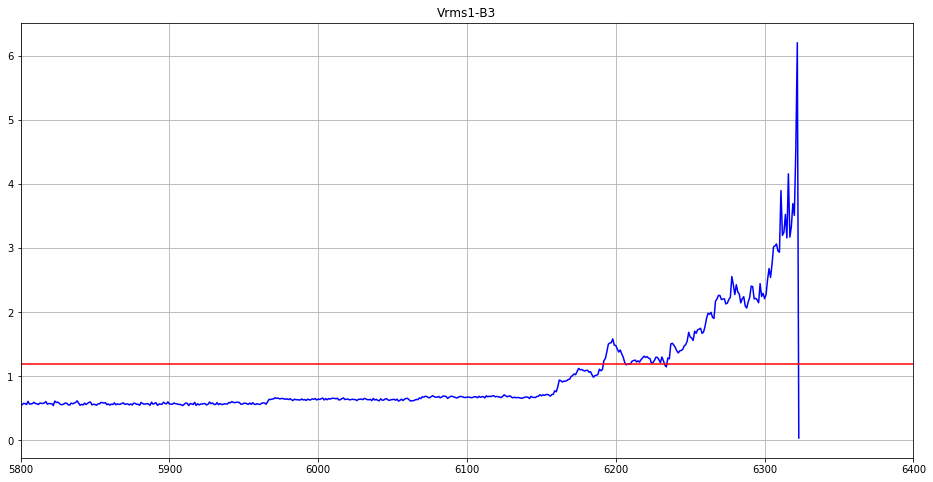

In [16]:
plt.figure(1, figsize = (16,8))
plt.title("Vrms1-B3")
plt.plot(Xt_all, 'b')
#plt.ylim([0, 1])
plt.xlim([5800,6400])
plt.grid()
plt.axhline(y=FPT_threshold, color='r', linestyle='-')
plt.show()

len(Xt_all) = 6324, len(Xt) = 132, FPT_idx = 6192



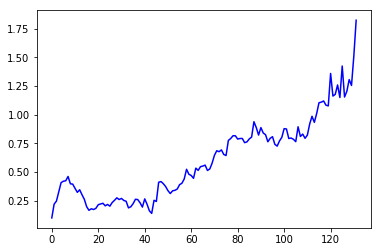

In [17]:
## get FPT at from Xt
FPT_idx = np.min(np.where(Xt_all > FPT_threshold))
FPT_idx
Xt = Xt_all[FPT_idx-1:-1] ## we start index from 1
St = np.log(Xt)
print("len(Xt_all) = %d, len(Xt) = %d, FPT_idx = %d\n" % (len(Xt_all), len(Xt), FPT_idx))
plt.plot(St, 'b')

In [0]:
# declare 
# theta ~ N(mu0, var0), beta ~ N(mu1, var1), var
# BM sigma
var_hat = []

# mu0, var0 : theta prior
mu0 = []
var0 = []

# mu1, var1 : beta prior
mu1 = []
var1 = []

# mu_theta, var_theta : theta posterior
mu_theta = []
var_theta = []

# mu_beta, var_beta : beta posterior
mu_beta = []
var_beta = []

# rho : posterior correlation
rho = []

In [0]:
# Step 1. initialize. k = 0
def init() :
    var_hat = []
    mu0 = []
    var0 = []
    mu1 = []
    var1 = []
    mu_theta = []
    var_theta = []
    mu_beta = []
    var_beta = []
    rho = []

    var_hat.append(1)
    mu0.append(0)
    var0.append(1)
    mu1.append(0)
    var1.append(1)
    mu_theta.append(0)
    var_theta.append(1)
    mu_beta.append(0)
    var_beta.append(1)
    rho.append(0.0)
    
    return (var_hat, mu0, var0, mu1, var1, mu_theta, var_theta, mu_beta, var_beta, rho)

In [0]:
def update_posterior(k):
    """
    from (k-1)-th prior
    update k-th posterior
    k-1 prior : sigma_hat[k-1], (mu0[k-1], sigma0[k-1]), (mu1[k-1], sigma1[k-1])
    """
    s1 = St[1]
    sk = St[k]
    t1 = 1 * T_delta
    tk = k * T_delta
    d = var_hat[k-1]
   # d = 0.1
    m0 = mu0[k-1]
    d0 = var0[k-1]
    m1 = mu1[k-1]
   # m1 = 1
    d1 = var1[k-1]
    
   # print("k = %d, s1 = %f, sk = %f, d = %f, m0 = %f, d0 = %f, m1 = %f, d1 = %f" % \
   #      (k, s1, sk, d, m0, d0, m1, d1))
    v1 = ((s1 * d0 + m0 * d * t1) * (d + d1 * tk) \
         - d0 * t1 * (d1 * sk + m1 * d - 0.5 * d**2)) \
    / ((d0 + d * t1) * (d1 * tk + d) - d0 * d1 * t1)
    
    v2 = d0 * d * t1 * (d + d1 * tk) / ((d0 + d * t1) * (d1 * tk + d) - d0 * d1 * t1)
    
    v111 = (sk*d1 + m1*d - 0.5*d**2)
    v112 = (d0 + d*t1)
    v12 = -1 * d1*(d0*s1 + m0*d*t1)
    v13 = (d0 + d*t1)*(d1*tk + d) - d0*d1*t1
   # v3 = ((sk * d1 + m1 * d - 0.5 * d**2) * (d0 + d * t1) - d1 * (d0 * s1 + m0 * d * t1)) \
   # / ((d0 + d * t1) * (d1 * tk + d) - d0 * d1 * t1)
    print("k=%d, sk=%f, m1*d=%f,v111=%f, v112=%f, v12=%f, v13=%f" % (k,St[k],m1*d,v111,v112,v12,v13))
    v3 = (v111*v112 + v12)/v13
    v4 = d1 * d * t1 * (d0 + d * t1) / ((d0 + d * t1) * (d1 * tk + d) - d0 * d1 * t1)
    
    v5 = (-1 * np.sqrt(d0 * d1) * np.sqrt(t1)) \
    / np.sqrt((d0 + d * t1) * (d1 * tk + d))

    return (v1, v2, v3, v4, v5)

In [0]:
def update_prior(k):
    """
    from (k-1)-th posterior
    update k-th prior
    """    
    s1 = St[1]
    sk = St[k]
    t1 = T_delta
    tk = k
    mt = mu_theta[k]
    mb = mu_beta[k]
  #  mb = 0.1
    dt = var_theta[k]
    db = var_beta[k]
    r = rho[k]

    v1 = mu_theta[k]
    v2 = var_theta[k]
    v3 = mu_beta[k]
    v4 = var_beta[k]


    ## sigma_hat
    tmp = 0
    if (k >= 2) :
        for i in range(2, k+1):
            tmp += ((St[i] - St[i-1])**2 - mb * T_delta * (St[i] - St[i-1]) + \
                    T_delta**2 * (mb**2 + db))/T_delta
            
    v5 = ((s1**2 - 2 * s1 * (mt + mb * t1) + dt + db + 2 * t1 * (r * np.sqrt(dt) * np.sqrt(db) + mt * mb) + t1**2 * (db + mb**2))/t1 + tmp )  / k  
    print("k=%d, tmp = %f, mb = %f, v5=%f" % (k, tmp, mb,v5))
    return (v1, v2, v3, v4, v5)

In [0]:
##def get_pdf_rul(k):
    
    
def get_predicted_trajectory():
  t = np.arange(0, len(mu_beta), T_delta)
  res = np.add(mu_theta, np.multiply(mu_beta, t))
  res = np.exp(res)
  return res

In [38]:
var_hat, mu0, var0, mu1, var1, mu_theta, var_theta, mu_beta, var_beta, rho = init()
for k in range(1, len(St)) :
    v1, v2, v3, v4, v5 = update_posterior(k)
    mu_theta.append(v1)
    var_theta.append(v2)
    mu_beta.append(v3)
    var_beta.append(v4)
    rho.append(v5)
    print("k=%d: (mt = %f, vt = %f, mb = %f, vb = %f, r = %f)" % (k, v1, v2, v3, v4, v5))

    v6, v7, v8, v9, v10 = update_prior(k)
    mu0.append(v6)
    var0.append(v7)
    mu1.append(v8)
    var1.append(v9)
    var_hat.append(v10) 
    print("k=%d: (m0=%f, v0=%f, m1=%f, v1=%f, v=%f)" % (k,v6,v7,v8,v9,v10))


k=1, sk=0.218454, m1*d=0.000000,v111=-0.281546, v112=2.000000, v12=-0.218454, v13=3.000000
k=1: (mt = 0.239485, vt = 0.666667, mb = -0.260515, vb = 0.666667, r = -0.500000)
k=1, tmp = 0.000000, mb = -0.260515, v5=1.333333
k=1: (m0=0.239485, v0=0.666667, m1=-0.260515, v1=0.666667, v=1.333333)
k=2, sk=0.245115, m1*d=-0.347354,v111=-1.072833, v112=2.000000, v12=-0.309966, v13=4.888889
k=2: (mt = 0.399904, vt = 0.484848, mb = -0.502288, vb = 0.363636, r = -0.288675)
k=2, tmp = 0.630032, mb = -0.502288, v5=0.771372
k=2: (m0=0.399904, v0=0.484848, m1=-0.502288, v1=0.363636, v=0.771372)
k=3, sk=0.324494, m1*d=-0.387451,v111=-0.566960, v112=1.256220, v12=-0.150688, v13=2.163126
k=3: (mt = 0.483838, vt = 0.321983, mb = -0.398920, vb = 0.162898, r = -0.274525)
k=3, tmp = 0.693383, mb = -0.398920, v5=0.333050
k=3: (m0=0.483838, v0=0.321983, m1=-0.398920, v1=0.162898, v=0.333050)
k=4, sk=0.406541, m1*d=-0.132860,v111=-0.122097, v112=0.655033, v12=-0.037708, v13=0.592522
k=4: (mt = 0.451019, vt = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in sqrt


In [36]:
print("len(mu_beta) = %d, len(mu_tetha) = %d\n" % (len(mu_beta), len(mu_theta)))
0.032392/18

len(mu_beta) = 132, len(mu_tetha) = 132



0.0017995555555555553

In [0]:
trj = get_predicted_trajectory()
len(trj)

353

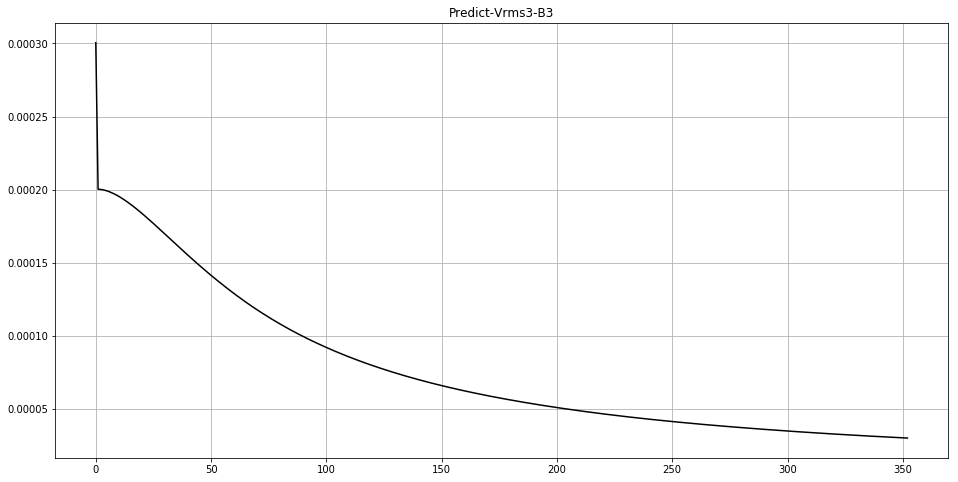

In [0]:
plt.figure(1, figsize = (16,8))
plt.title("Predict-Vrms3-B3")
#plt.plot(St, 'b')
#plt.plot(Xt, 'r')
#plt.plot(trj, 'g')
plt.plot(var_theta, 'k')
#plt.xlim([0,50])
plt.grid()
plt.show()

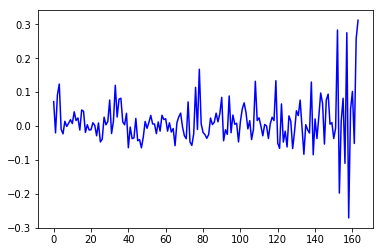

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in subtract
  


array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [0]:
tmp = []
for i in range(2,len(St)) :
  tmp.append((St[i] - St[i-1]))
  #print ( "k=%d, diff^2 = %f" % (i, (St[i] - St[i-1])**2))

plt.plot(tmp, 'b')
plt.show()
np.subtract(mu1,mu_beta)